# Entrainer les agents addi

## Settings

In [1]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE.git
    %ls
else:
    print("on n'est pas sur colab")

Reinitialized existing Git repository in /content/.git/
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/vincentvigon/RECHERCHE
 * branch            HEAD       -> FETCH_HEAD
Updating 31fda76..71b87d2
Fast-forward
 Euler/agent_addi.py         | 4 +++-
 Euler/initial_conditions.py | 1 -
 2 files changed, 3 insertions(+), 2 deletions(-)
 ddqn_lib/   Euler/  'Icon'$'\r'   popup_lib/   sample_data/   toto.py*


In [2]:
%reset -f

In [3]:
import Euler.core_solver as core
import Euler.agent_addi as aga
import Euler.initial_conditions as init

#from Euler.backend import K
import matplotlib.pyplot as plt
import Euler.neural_networks as nn
from Euler.backend import K
from Euler.param import Param,Projecter

import popup_lib.popup as pop
import numpy as np
import copy

Popup loaded!


### Paramètres globaux

ça serait bien d'essayer l'entrainement avec des conditions de neumann. Le générateur de fonction est beaucoup plus générique (mais plus lent). 

Attention à la génération: si les fonctions sont trop grandes cela pête dès le début. 

In [4]:
param = Param(nx=1000,batch_size=64,nx_ratio=10,BC="periodic")
param.gen_fourierGlobConstant = 0.1
param.gen_periodicDiscont_maxHeightRatio = 0.5
param.sod_scale = 1
param.initial_speed_factor=0
k=K("tf",32)

Param initialised with, nx=1000, nx_coarse=99, batch_size=64


## Observons le solver

### générateur de fonction

Les fonctions de base avec le nouveau générateur "neumann"

In [5]:
def test_generate_func():
    res=init.generate_func(param,k)
    print(res.shape)

    fig, axs = plt.subplots(5, 5,figsize=(15,15))
    axs = axs.flatten()

    for i in range(25):
        axs[i].plot(res[i,:])

    plt.show()

(64, 1000)


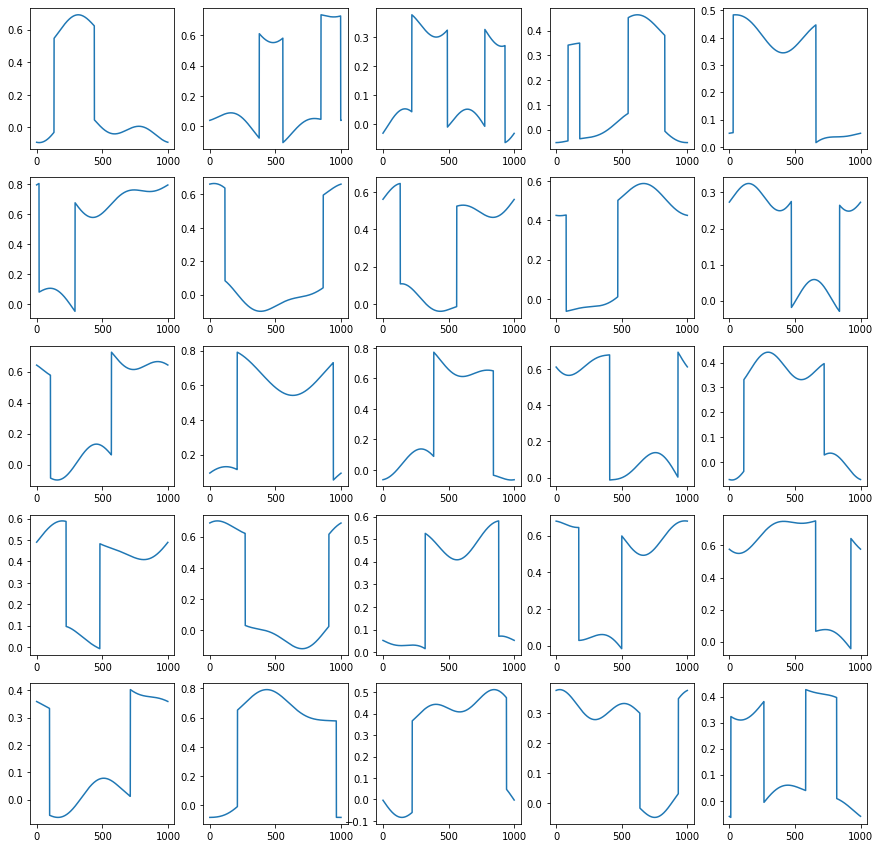

In [6]:
test_generate_func()

### Les 3 quantités

Une donnée `W`, c'est un batch de triplet $\rho,\rho V,E$

In [7]:
W = init.init_W(param, k)
W.shape

TensorShape([64, 1000, 3])

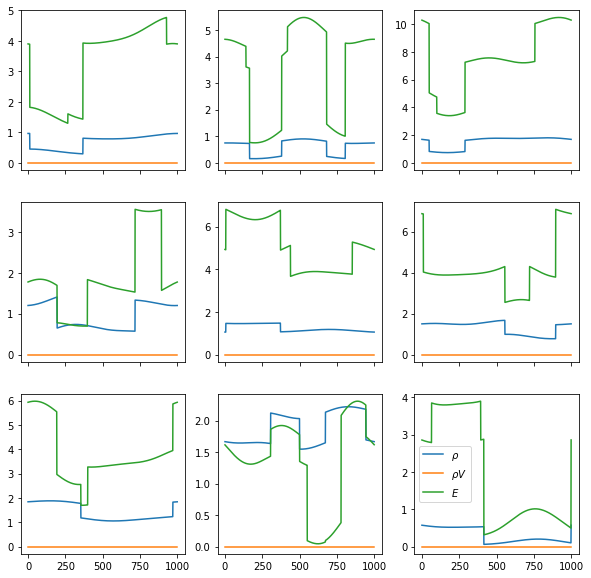

In [8]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

for i in range(9):
    axs[i].plot(W[i,:,0],label=r"$\rho$")
    axs[i].plot(W[i,:,1],label=r"$\rho V$")
    axs[i].plot(W[i,:,2],label="$E$")
plt.legend()
plt.show()

### Projection

In [9]:
projecter=Projecter(param.nx_ratio,32)

In [10]:
W_proj=projecter.projection(W)
W_proj.shape

TensorShape([64, 99, 3])

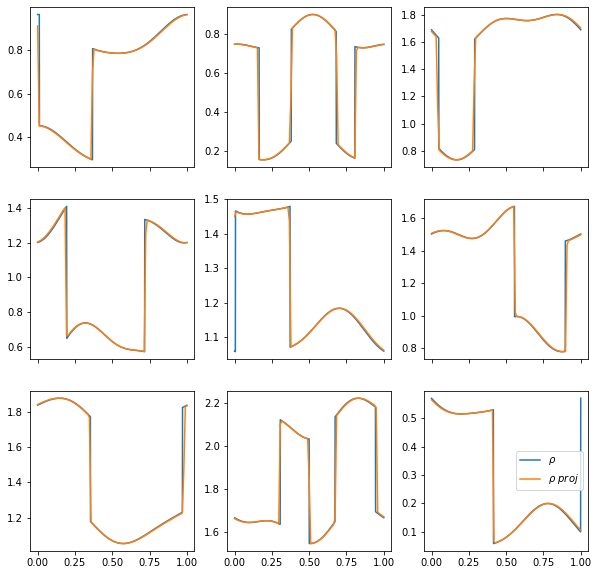

In [11]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

x=np.linspace(param.xmin,param.xmax,param.nx)
x_proj=np.linspace(param.xmin,param.xmax,param.nx_coarse)
for i in range(9):
    axs[i].plot(x,W[i,:,0],label=r"$\rho$")
    axs[i].plot(x_proj,W_proj[i,:,0],label=r"$\rho\ proj$")
    
plt.legend()
plt.show()

### Dynamique

In [12]:
nb_t = 500
W_coarse=W_proj

res=core.compute_solutions(param, nb_t, W, False,k)
res_coarse=core.compute_solutions(param, nb_t, W_coarse, True,k)

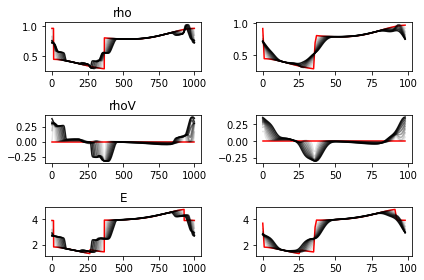

In [13]:
fig, ax = plt.subplots(3, 2)

for t in range(0, nb_t, nb_t // 10):
    color = "r" if t == 0 else "k"
    alpha = 1 if t == 0 else t / nb_t
    ax[0,0].set_title("rho")
    ax[0,0].plot(res[t, 0, :, 0], color, alpha=alpha)
    ax[0,1].plot(res_coarse[t, 0, :, 0], color, alpha=alpha)
    ax[1,0].set_title("rhoV")
    ax[1,0].plot(res[t, 0, :, 1], color, alpha=alpha)
    ax[1,1].plot(res_coarse[t, 0, :, 1], color, alpha=alpha)
    ax[2,0].set_title("E")
    ax[2,0].plot(res[t, 0, :, 2], color, alpha=alpha)
    ax[2,1].plot(res_coarse[t, 0, :, 2], color, alpha=alpha)

fig.tight_layout()

plt.show()

### Comparons fine et HLL

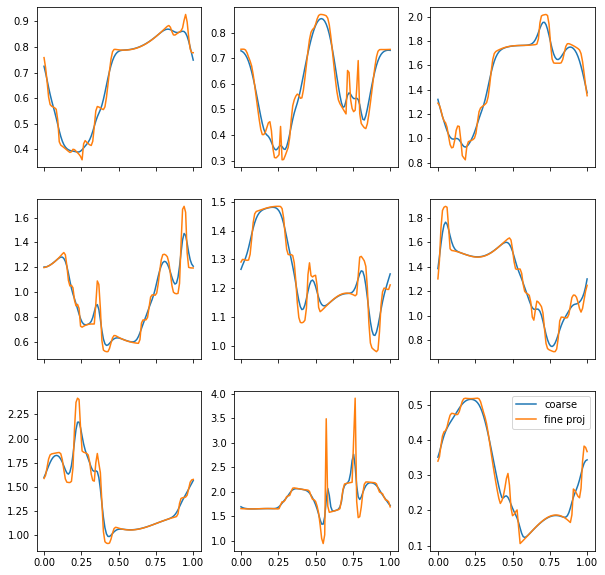

In [14]:
fig,axs=plt.subplots(3,3,sharex="all",figsize=(10,10))
axs=axs.flatten()

for i,ax in enumerate(axs):
    ax.plot(x_proj,res_coarse[-1, i, :, 0],label="coarse")
    res_proj=projecter.projection(res[-1])
    ax.plot(x_proj,res_proj[i, :, 0],label="fine proj")
ax.legend();

## Des familles d'agents

In [15]:
fam_size=6
period_duration="60 seconds"
all_agents=[]

### Agents et familyTrainers

In [16]:
def family_full(window_size,color):
        name="full_"+str(window_size)
        agents=[]
        for _ in range(fam_size):
            agent= aga.Agent_addi(param, nn.Difference_model_addi(param,window_size),
                            loss_stability_over_HLL=0.8, #0=> on ne décolle pas de HLL, >1 => on force à s'éloigner de HLL
                            nb_optimization=15,
                            watch_duration=20
                            )
            agents.append(agent)
            all_agents.append(agent)
            
        return pop.Family_trainer(
            agents=agents,
            nb_bestweights_averaged=3,
            nb_strong=3,
            period_duration=period_duration,
            name=name,
            color=color)

family_trainers=[
                 family_full(5,"red"),
                 #family_full(3,"blue"),
                 ]

### chargement des datas

On pourrait aussi s'amuser à alterner les 2 méthodes de générations des fonctions (periodic et neumann). 

In [17]:
#global_count={"count":-1}

In [18]:
def load_data():
    # global_count["count"]+=1
    # if global_count["count"]%2==0:
    #     param.BC="periodic"
    # else:
    #     param.BC="neumann"

    W_train, Y_train = core.compute_fine_solutions_3(param, nb_t)
    W_val, Y_val = core.compute_fine_solutions_3(param, nb_t)
    for agent in all_agents:
        agent.load_WY_train(W_train, Y_train)
        agent.load_WY_valid(W_val, Y_val)

### Entrainement

In [19]:
try:
    for i in range(50):
        load_data()
        for family_trainer in family_trainers:
            family_trainer.period()
except KeyboardInterrupt:
    for family_trainer in family_trainers:
        #pour pouvoir reprendre si on veut
        family_trainer.interupt_period()
    pass

durée du calcul de la solution fine: 1.7587625980377197durée du calcul de la solution fine: 1.613222360610962
full_5,échauffement a↗1.0957b↗1.0437c↗1.0533d↗1.0534e↗1.0256f↗1.0913durée du calcul de la solution fine: 1.5983333587646484durée du calcul de la solution fine: 1.5952329635620117
full_5,period:1 a↗1.4449b↗1.1889c↗1.1654d↗1.1957_f↗1.3327_, mutations:a↫a|durée du calcul de la solution fine: 1.6035656929016113durée du calcul de la solution fine: 1.598006248474121
full_5,period:2 _____, mutations:b⇇d|durée du calcul de la solution fine: 1.5889480113983154durée du calcul de la solution fine: 1.7030794620513916
full_5,period:3 __c↗1.4463d↗1.6885__, mutations:e⇇a|durée du calcul de la solution fine: 1.5922017097473145durée du calcul de la solution fine: 1.5961112976074219
full_5,period:4 __c↗1.6667__f↗1.7693, mutations:b⇇d⇇c|durée du calcul de la solution fine: 1.609349250793457durée du calcul de la solution fine: 1.6063251495361328
full_5,period:5 _____, mutations:b⇇d⇇c⇇c|durée du ca

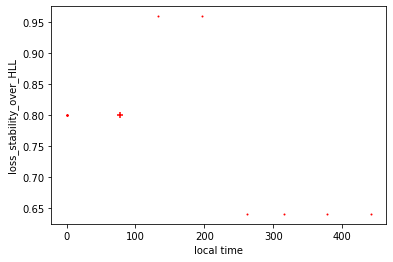

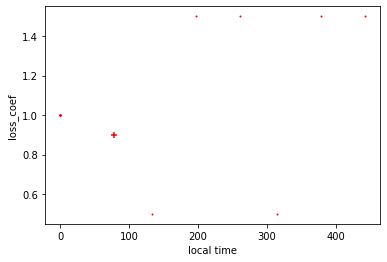

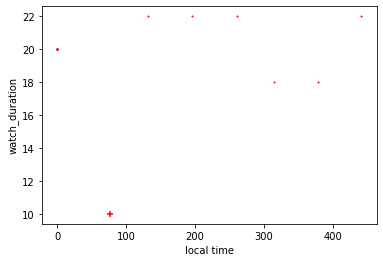

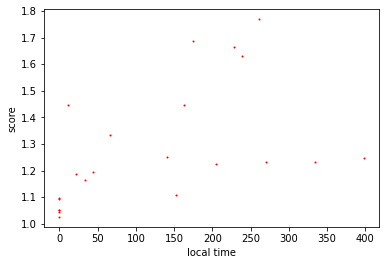

In [20]:
keys=["loss_stability_over_HLL","loss_coef","watch_duration","score"]

for k in keys:
    fig,ax=plt.subplots()
    for family_trainer in family_trainers:
        family_trainer.plot_metric(k,ax)

plt.show()

## Testons sur le jeu "periodic"

In [21]:
import tensorflow as tf
family_trainer=family_trainers[0]
best_agent=family_trainer.get_best_agent()
param=best_agent.param
k=K("tf",32)
nb_t=500

In [22]:
param.BC="periodic"
W_val, Y_val = core.compute_fine_solutions_3(param, nb_t)
best_agent.load_WY_valid(W_val, Y_val)

durée du calcul de la solution fine: 1.7355544567108154

In [23]:
def check_Nan_compute_errors():
    w_coarse, w_final_projected=best_agent.give_results(True)
    w_coarse_HLL, _=best_agent.give_results(False)

    nans0=tf.math.is_nan(tf.reduce_sum(w_coarse,axis=[1,2]))
    print("\nnombre de Nan produit par le modèle:",tf.reduce_sum(tf.cast(nans0,tf.int32)).numpy())
    nans1=tf.math.is_nan(tf.reduce_sum(w_coarse_HLL,axis=[1,2]))
    print("nombre de Nan produit par HLL:",tf.reduce_sum(tf.cast(nans1,tf.int32)).numpy())
    nans2=tf.math.is_nan(tf.reduce_sum(w_final_projected,axis=[1,2]))
    print("nombre de Nan dans la solution de référence:",tf.reduce_sum(tf.cast(nans2,tf.int32)).numpy())

    nans=nans0|nans1|nans2

    errors_model=np.abs(w_coarse - w_final_projected)[~nans]
    errors_HLL=np.abs(w_coarse_HLL - w_final_projected)[~nans]

    error_model=np.mean(errors_model)
    error_HLL = np.mean(errors_HLL)
    score=error_HLL/error_model

    print("error_model",error_model)
    print("error_HLL",error_HLL)
    print("score",score)

    return w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL


In [24]:
w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL=check_Nan_compute_errors()


nombre de Nan produit par le modèle: 4
nombre de Nan produit par HLL: 0
nombre de Nan dans la solution de référence: 0
error_model 0.034847986
error_HLL 0.06482115
score 1.8601117


Ce que produise nos modèles

In [25]:
def for_one_channel(channel,w_coarse,w_coarse_HLL, w_final_projected):
    fig,axs=plt.subplots(6,2,figsize=(9,20))
    fig.suptitle(family_trainer.name)
    axs=axs.flatten()
    xs=np.linspace(param.xmin,param.xmax,param.nx_coarse)
    ax=None
    for i,ax in enumerate(axs):
        ax.plot(xs,w_final_projected[i,:,channel],label="fine",color="black")
        ax.plot(xs,w_coarse_HLL[i,:,channel],label="HLL",color="blue")
        ax.plot(xs,w_coarse[i,:,channel],label="model",color="red")
    ax.legend()

### Densités

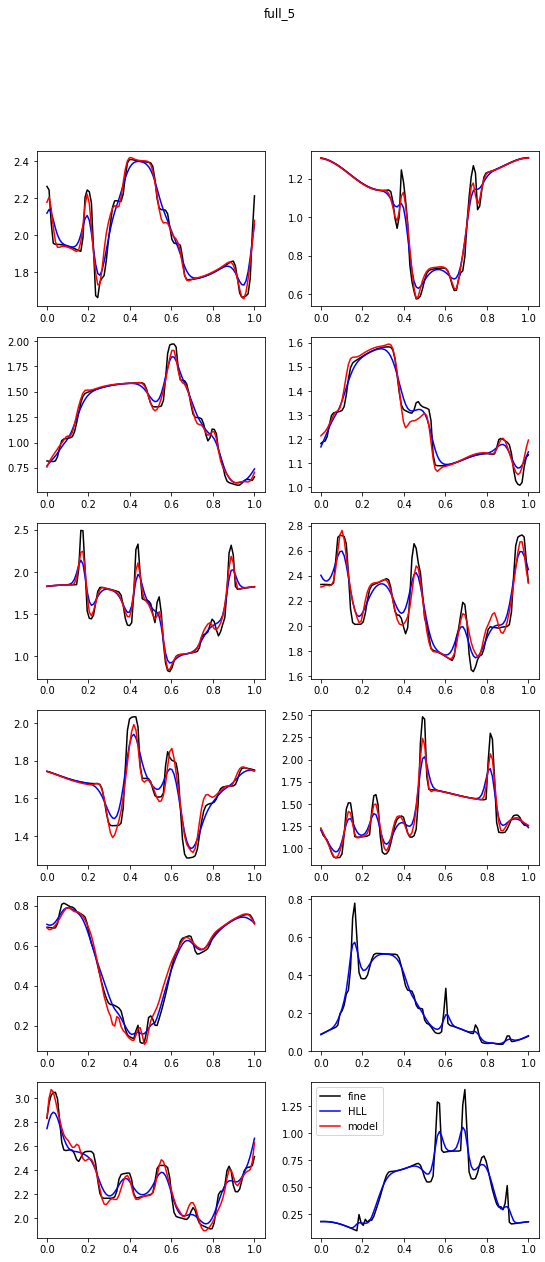

In [26]:
for_one_channel(0,w_coarse,w_coarse_HLL, w_final_projected)

### rho V

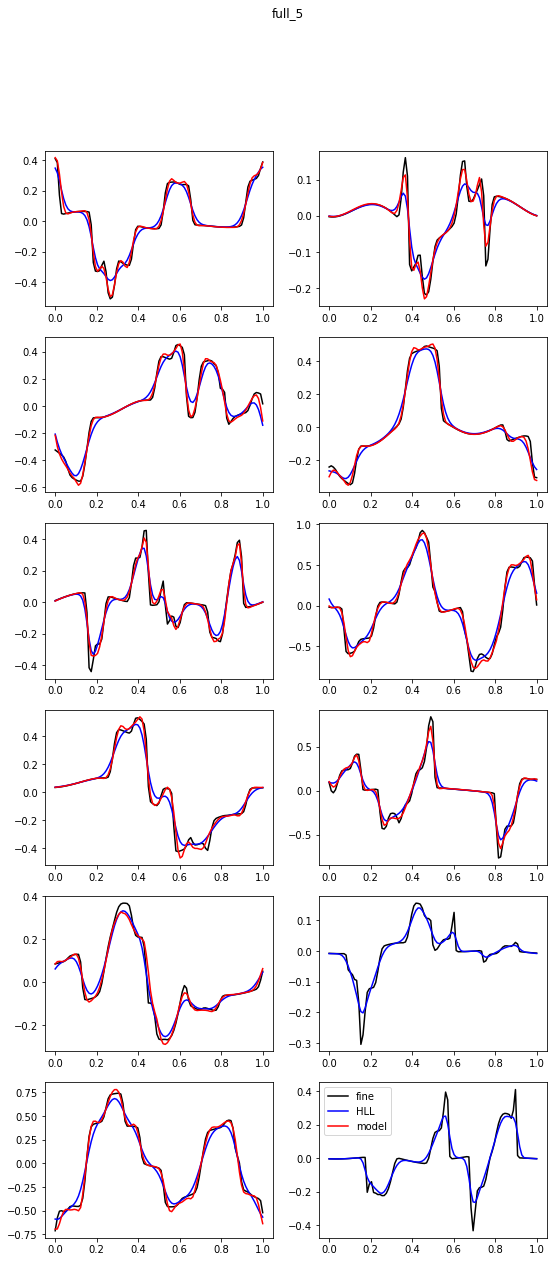

In [27]:
for_one_channel(1,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

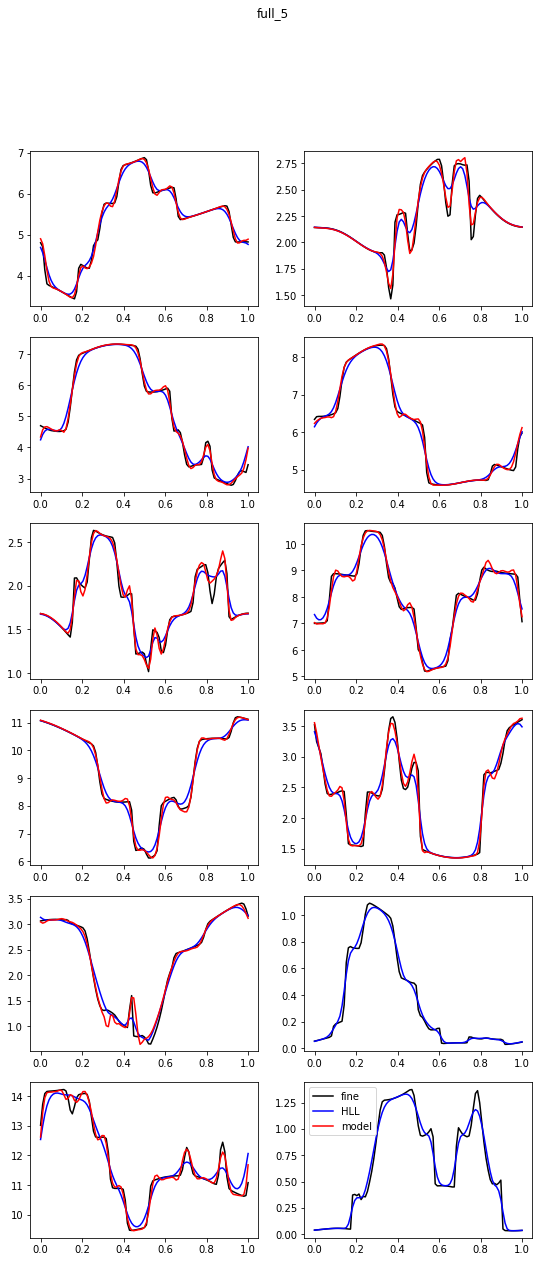

In [28]:
for_one_channel(2,w_coarse,w_coarse_HLL, w_final_projected)

### Pair plot

In [29]:
def pair_plot(errors_model,errors_HLL):    
    
    all_errors_model=np.reshape(errors_model,[-1,3])
    all_errors_HLL=np.reshape(errors_HLL,[-1,3])

    fig,ax0=plt.subplots(figsize=(9,9))
    fig.suptitle(family_trainer.name)
    ax0.scatter(all_errors_HLL[:,0],all_errors_model[:,0],s=1,color='r',alpha=0.5,label=r"$\rho$")
    ax0.scatter(all_errors_HLL[:,1],all_errors_model[:,1],s=1,color='g',alpha=0.5,label=r"$\rho V$")
    ax0.scatter(all_errors_HLL[:,2],all_errors_model[:,2],s=1,color='b',alpha=0.5,label=r"$E$")
    ax0.legend()
    xx=np.linspace(0,2,10)
    ax0.set_xlabel("errors_HLL")
    ax0.set_ylabel("errors_model")
    ax0.set_ylim(0,2)
    ax0.set_xlim(0,2)
    ax0.plot(xx,xx,"k")

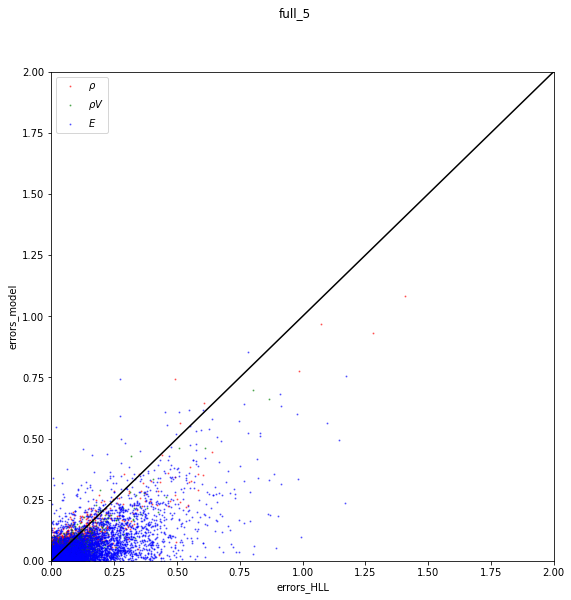

In [30]:
pair_plot(errors_model,errors_HLL)

## Testons sur des solutions non-périodiques

In [31]:
param.BC="neumann"
W_val, Y_val = core.compute_fine_solutions_3(param, nb_t)
best_agent.load_WY_valid(W_val, Y_val)

durée du calcul de la solution fine: 2.0770506858825684

In [32]:
w_coarse, w_final_projected,w_coarse_HLL,errors_model,errors_HLL=check_Nan_compute_errors()


nombre de Nan produit par le modèle: 1
nombre de Nan produit par HLL: 0
nombre de Nan dans la solution de référence: 0
error_model 0.008902598
error_HLL 0.013560221
score 1.5231756


### Des sauts plus variées:

Avec BC="neumann", je me suis laché sur la génération de fonction. Notamment, les discontinuités au sein d'une même fonction ont des tailles variables.

Par contre: j'avais testé avec des discontinuités "neumann" 10 fois plus grandes que celles de periodic, cela produisait pas mal de nan, et des résultats plus médiocre. 

In [33]:
def test_generate_func(is_neumann):
    param = Param(1000, 9)
    if is_neumann:
        param.BC = "neumann"
    else:
        param.BC= "periodic"
    k=K("tf",32)
    
    res=init.generate_func(param,k)
    print(res.shape)

    fig, axs = plt.subplots(3, 3,figsize=(10,10))
    axs = axs.flatten()

    for i in range(9):
        axs[i].plot(res[i,:])

    plt.show()

Param initialised with, nx=1000, nx_coarse=99, batch_size=9
(9, 1000)


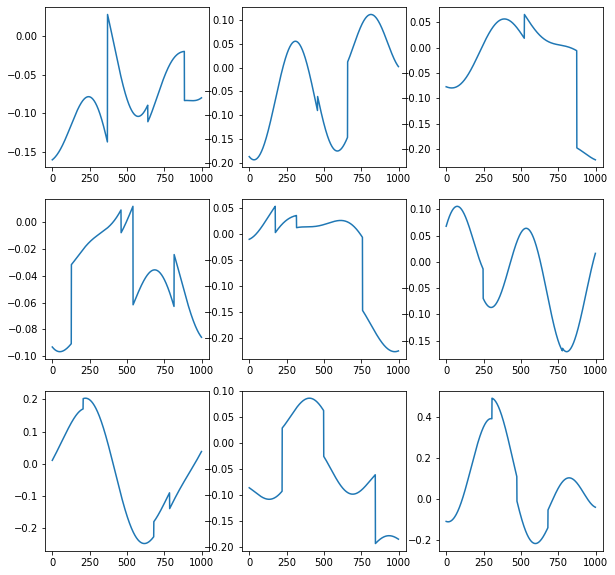

In [34]:
test_generate_func(True)

Param initialised with, nx=1000, nx_coarse=99, batch_size=9
(9, 1000)


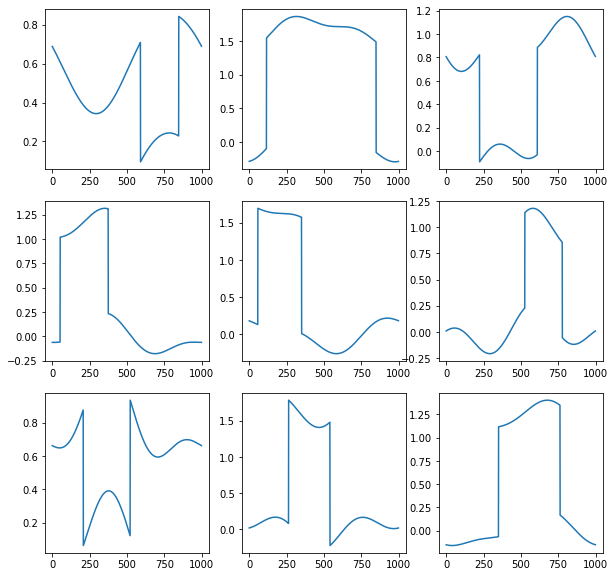

In [35]:
test_generate_func(False)

### Densités

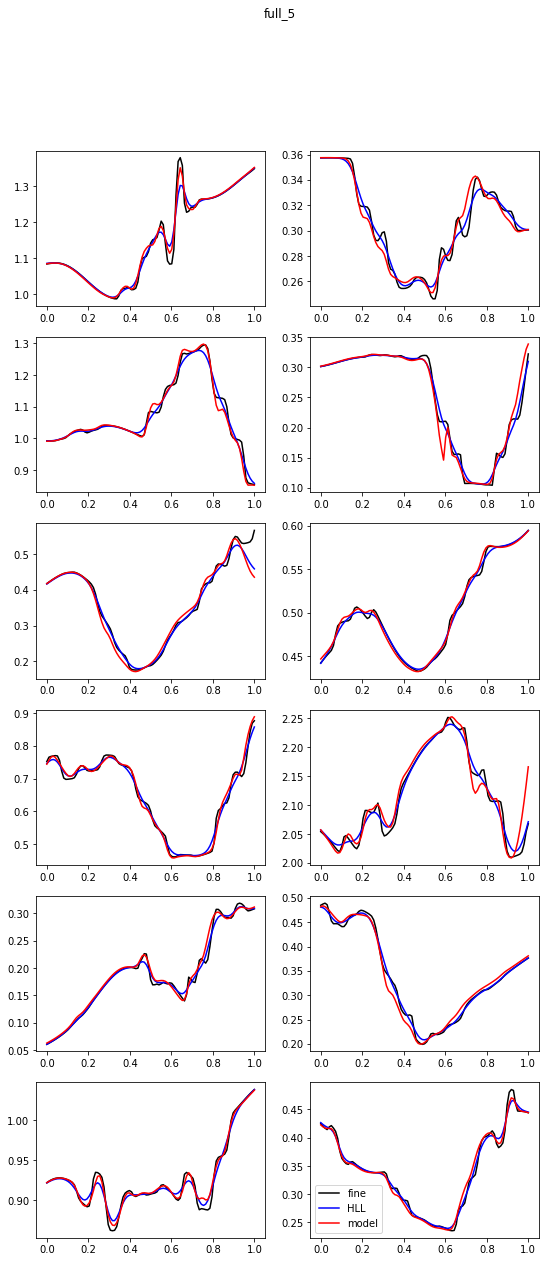

In [36]:
for_one_channel(0,w_coarse,w_coarse_HLL, w_final_projected)

### rho V

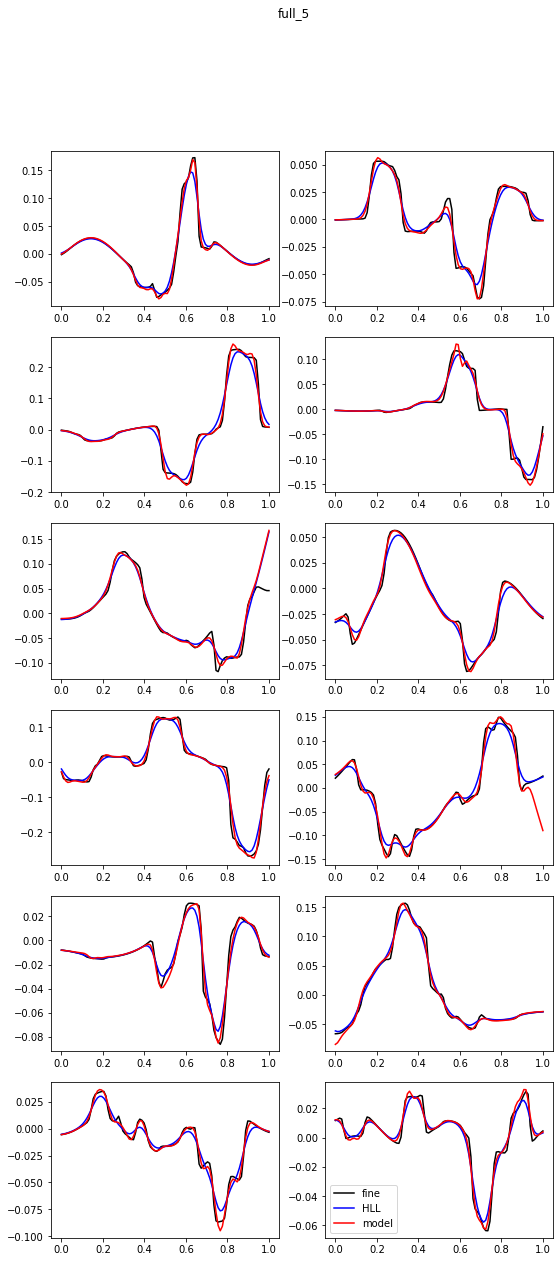

In [37]:
for_one_channel(1,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

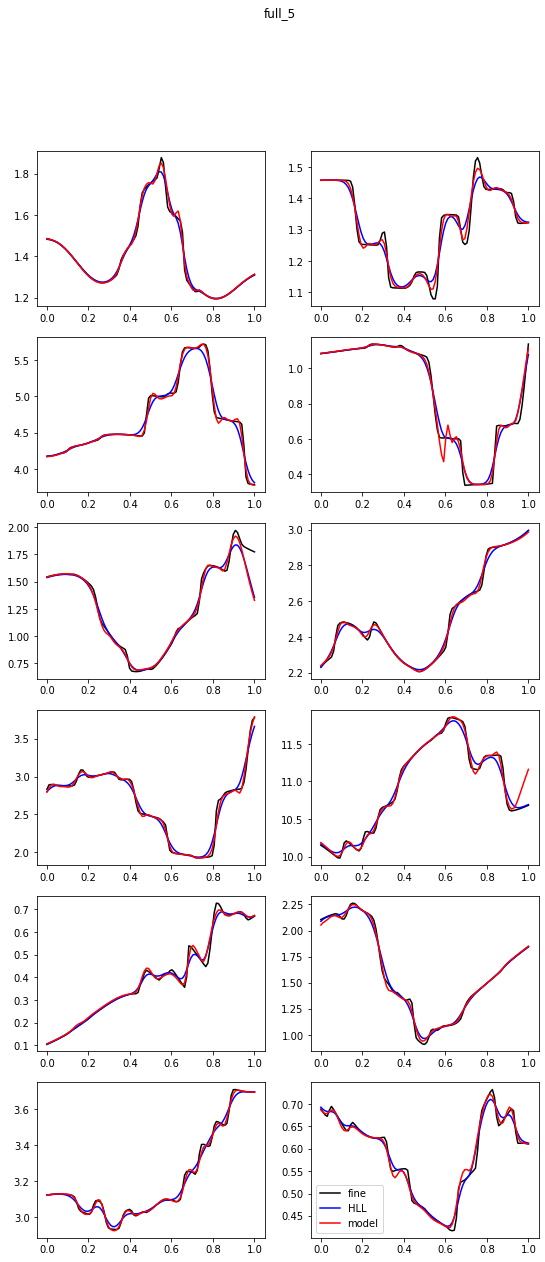

In [38]:
for_one_channel(2,w_coarse,w_coarse_HLL, w_final_projected)

### Energie

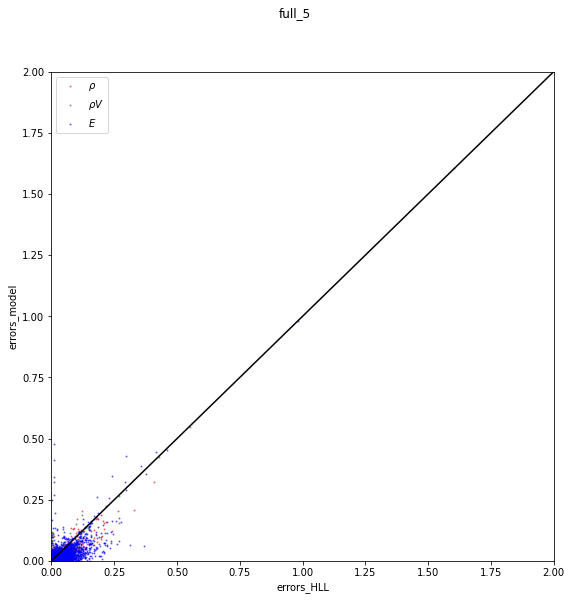

In [39]:
pair_plot(errors_model,errors_HLL)

## Testons le long du temps

In [40]:
def compare_along_the_time(test_case):
    
    model_addi=best_agent.model
    W_init = init.init_W(param, k, test_case=test_case)

    nb_t = 500

    proj=Projecter(param.nx_ratio,32)
    print(W_init.shape)
    W_init_coarse=proj.projection(W_init)
    
    res_fine=core.compute_solutions(param, nb_t, W_init, False,k)
    res_fine_proj=[proj.projection(res) for res in res_fine]
    res_fine_proj=k.stack(res_fine_proj)

    res_coarse=core.compute_solutions(param, nb_t, W_init_coarse, True,k)

    res_coarse_model=[]
    w_coarse=W_init_coarse
    for t in range(nb_t):

        var = core.Var_burger(w_coarse, param, k)
        Fnum_HLL = core.Flux_HLL(var, param, k)
        dFnum_HLL = (Fnum_HLL[:, 1:, :] - Fnum_HLL[:, :-1, :])

        X = var.get_augmentation()
        addi = model_addi(X,False)
        dFnum=dFnum_HLL+addi

        w_coarse = w_coarse - param.dt_over_dx_coarse * dFnum
        res_coarse_model.append(w_coarse)
    res_coarse_model=k.stack(res_coarse_model)

    step=100
    nb_res=nb_t // step
    fig, ax = plt.subplots(nb_res,figsize=(10,nb_res*3))

    for i in range(nb_res):
        t=i*step
        ax[i].plot(res_fine_proj[t,0,:,0],color="k",label="HLL")
        ax[i].plot(res_coarse[t,0,:,0],color="b",label="HLL")
        ax[i].plot(res_coarse_model[t,0,:,0],color="r",label="HLL")
        
    ax[0].legend()    
    fig.tight_layout()
    
    
    errors_HLL=tf.reduce_mean((res_fine_proj-res_coarse)**2,axis=[1,2,3])
    errors_model=tf.reduce_mean((res_fine_proj-res_coarse_model)**2,axis=[1,2,3])

    fig,ax=plt.subplots()
    ax.plot(errors_HLL,label="HLL")
    ax.plot(errors_model,label="model")
    ax.legend()
    ax.set_xlabel("time")

    plt.show()

### case Random

(64, 1000, 3)


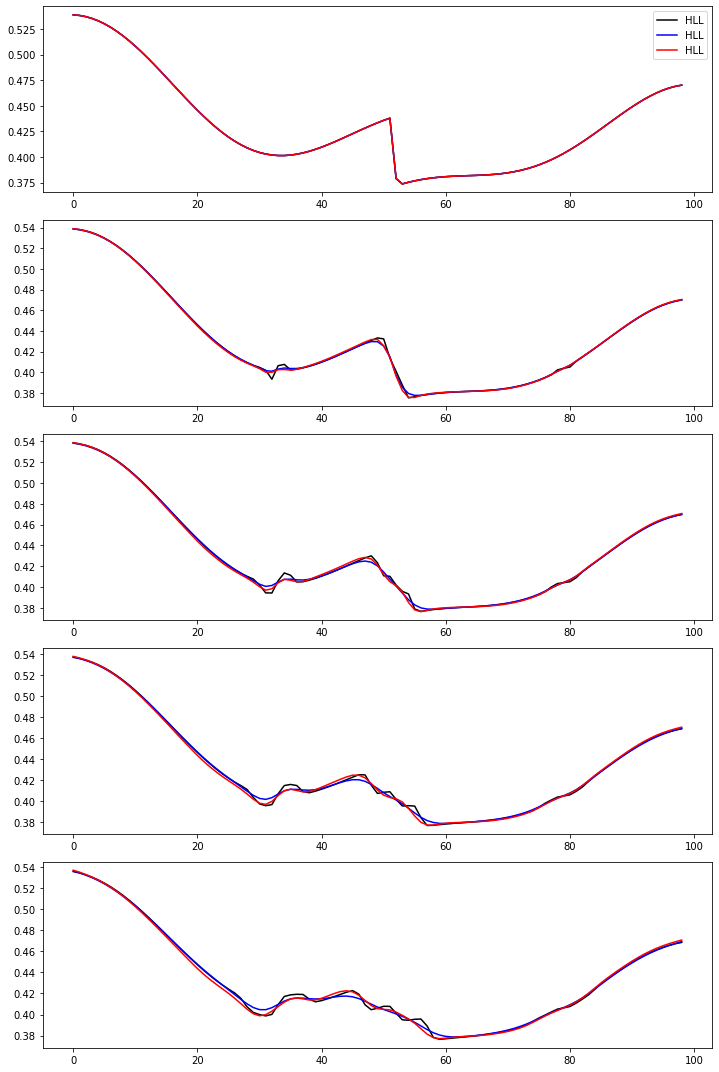

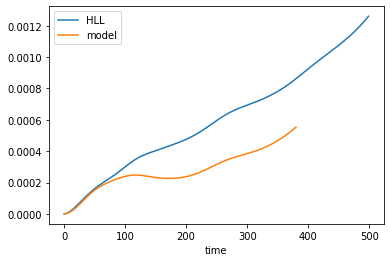

In [41]:
compare_along_the_time("random")

### Case sod

(64, 1000, 3)


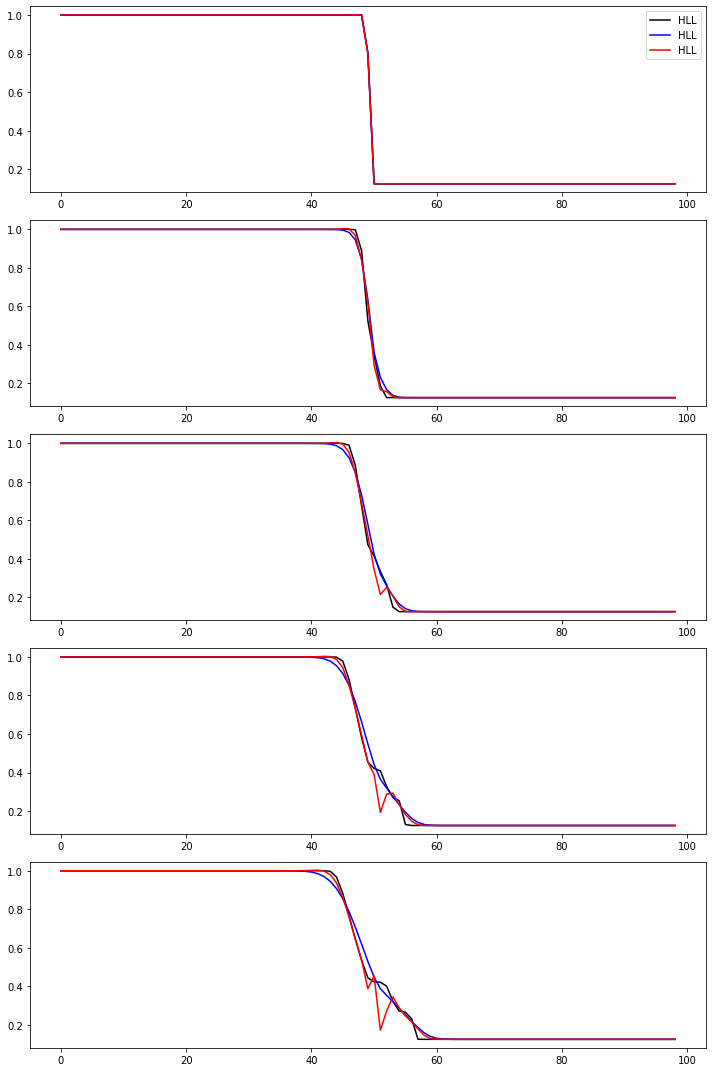

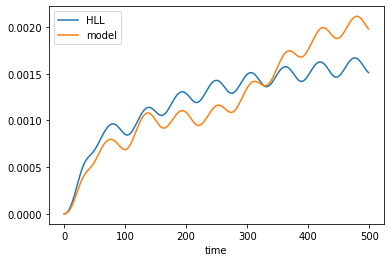

In [43]:
compare_along_the_time("sod")